**1. Визначити сутність і виконати аналіз функцій парного блокуючого обміну.**

Парний блокуючий обмін - це базова модель взаємодії двох процесів у MPI, коли один процес надсилає повідомлення, а інший його приймає, і обидві операції є блокуючими, тобто процес зупиняється, доки виклик не завершиться.

У парному обміні беруть участь два процеси: відправник і одержувач.

Відправник викликає функцію MPI_Send, передаючи адресу буфера, тип даних, кількість елементів, тег повідомлення та ранг процесу-одержувача.

Одержувач викликає MPI_Recv з аналогічними параметрами, вказуючи, від кого він чекає повідомлення та який тип і тег має відповідати.

Блокуюча відправка означає, що процес-відправник не продовжить виконання, поки MPI не буде повністю впевнена, що параметри буфера можна безпечно змінювати - або тому, що дані вже гарантовано передані, або тому, що вони скопійовані у внутрішній буфер MPI.

Важливою частиною парного обміну є узгодженість параметрів: обидві сторони мають співпасти за типом даних, розміром та тегом. Це забезпечує коректність і запобігає неоднозначності.

Блокуючі виклики забезпечують ряд важливих властивостей.
 * Кожен MPI_Recv отримає саме те повідомлення, якого він очікує.
 * Вони забезпечують локальну синхронізацію між процесами. Хоча MPI_Send не зобов’язаний чекати фактичного прийому, у більшості реалізацій прості повідомлення передаються одразу, і відправник блокується тільки до моменту копіювання в буфер MPI.
 * Парний блокуючий обмін може бути джерелом взаємних блокувань (deadlock), якщо обидва процеси викликають MPI_Send, не маючи активних прийомів. Наприклад, двостороння відправка без попереднього MPI_Recv може заблокувати програму, якщо реалізація MPI не має достатньо буфера для обох повідомлень.
 * Також, важливо розуміти його семантику: завершення відправки не означає, що повідомлення доставлене одержувачу. Завершення прийому означає, що дані гарантовано знаходяться у буфері одержувача.

In [1]:
!pip install mpi4py


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


**Тестова програма для перевірки роботи бібліотеки в середовищі Jupiter Notebook**

In [2]:
%%writefile test_mpi.py
from mpi4py import MPI
comm = MPI.COMM_WORLD
print(f"Rank: {comm.Get_rank()} | Size: {comm.Get_size()}")

Overwriting test_mpi.py


In [3]:
!mpiexec -n 4 python test_mpi.py

Rank: 1 | Size: 4
Rank: 0 | Size: 4


Rank: 2 | Size: 4
Rank: 3 | Size: 4




**2. Побудувати програму-шаблон для парного блокуючого обміну**

In [4]:
%%writefile task2.py
from mpi4py import MPI

# function to return whether a number of a process is odd or even
def odd(number):
    if (number % 2) == 0:
        return False
    else :
        return True

def main():
    comm = MPI.COMM_WORLD
    id = comm.Get_rank()            #number of the process running the code"
    numProcesses = comm.Get_size()  #total number of processes running"
    myHostName = MPI.Get_processor_name()  #machine name running the code"

    # num of processes must be even
    if numProcesses > 1 and not odd(numProcesses):
        sendValue = id

         #odd processes receive from their paired 'neighbor', then send
        if odd(id):
            comm.send(sendValue, dest=id - 1)
            receivedValue = comm.recv(source=id - 1)

        #even processes receive from their paired 'neighbor', then send
        else:
            receivedValue = comm.recv(source=id + 1)
            comm.send(sendValue, dest=id + 1)

        print(
            "Process {} of {} on {} computed {} and received {}".format(
                id, numProcesses, myHostName, sendValue, receivedValue
            )
        )

    else:
        if id == 0:
            print("Please run this program with a positive even number of processes.")

if __name__ == "__main__":
    main()


Overwriting task2.py


In [5]:
!mpiexec -n 6 python task2.py

Process 2 of 6 on DESKTOP-L6FRMTM computed 2 and received 3
Process 4 of 6 on DESKTOP-L6FRMTM computed 4 and received 5

Process 3 of 6 on DESKTOP-L6FRMTM computed 3 and received 2

Process 5 of 6 on DESKTOP-L6FRMTM computed 5 and received 4


Process 0 of 6 on DESKTOP-L6FRMTM computed 0 and received 1
Process 1 of 6 on DESKTOP-L6FRMTM computed 1 and received 0


Як можемо бачити з цього прикладу, дані попарно відправляються між процесами один одному.

Процес 1, відправив процесу 0 значення свого рангу "1", а процес 0 в свою чергу, відправив процесу 1 аналогічно - "0"

**Атрибути функцій обміну (Send / Recv):**

У блокуючому парному обміні беруть участь такі параметри:

* buf - область памʼяті з даними для передачі або прийому.
* count - кількість елементів у буфері.
* datatype - MPI-тип одного елемента (MPI_INT, MPI_DOUBLE, масиви NumPy і т.д.).
* dest / source - ранг процесу, якому надсилаємо або від якого очікуємо повідомлення.
* tag - ціле число для логічної ідентифікації виду повідомлення.
* comm - комунікатор (наприклад, MPI_COMM_WORLD).
* status (тільки для Recv) - структура, у якій після завершення зберігається фактичний відправник, тег та код завершення.

**Аналіз типів даних:**
1. MPI не робить автоматичного перетворення типів: тип відправника і одержувача має збігатися.
2. count і datatype однозначно визначають обсяг памʼяті, що MPI повинна передати.
3. Якщо count = 0, операція дозволена й завершується миттєво.
4. Розмір приймального буфера повинен бути не меншим, ніж фактичний розмір отриманих даних - інакше помилка.
5. У mpi4py:
  * send(obj) - обʼєкт серіалізується, тип визначається автоматично.
  * Send([...], MPI.INT) - передаються сирі дані з чітким типом і розміром.
6. Типи даних визначають спосіб розбору байтів, тому невідповідність типів призводить до некоректного читання або помилки.

**Семантичний аналіз парного блокуючого обміну**

1. Операція MPI_Send блокується, поки MPI не гарантує, що буфер можна змінювати (дані або передані, або скопійовані в буфер MPI).
2. MPI_Recv блокується, поки дані не будуть повністю отримані і записані в приймальний буфер.
3. Відправник та одержувач повинні бути логічно узгоджені: однаковий tag, однаковий datatype, однаковий count, коректно вказані source/dest
4. Порушення симетрії веде до дедлоку (наприклад, обидва процеси одночасно викликають Send і жоден не виконує Recv).
5. Завершення Send не означає, що одержувач вже отримав повідомлення - лише те, що відправник може використовувати буфер.
6. Завершення Recv означає, що дані гарантовано у приймальному буфері.
7. Парний блокуючий обмін створює локальну синхронізацію між процесами: один процес не може рухатись далі, доки пара не виконає узгоджену операцію.

**Змінимо в програмі порядок виконання функцій для парних рангів, щоб продемострувати дедлок**

In [6]:
%%writefile task2_deadlock.py
from mpi4py import MPI

# function to return whether a number of a process is odd or even
def odd(number):
    if (number % 2) == 0:
        return False
    else :
        return True

def main():
    comm = MPI.COMM_WORLD
    id = comm.Get_rank()            #number of the process running the code"
    numProcesses = comm.Get_size()  #total number of processes running"
    myHostName = MPI.Get_processor_name()  #machine name running the code"

    # num of processes must be even
    if numProcesses > 1 and not odd(numProcesses):
        sendValue = id

         #odd processes receive from their paired 'neighbor', then send
        if odd(id):
            receivedValue = comm.recv(source=id - 1)
            comm.send(sendValue, dest=id - 1)

        #even processes receive from their paired 'neighbor', then send
        else:
            receivedValue = comm.recv(source=id + 1)
            comm.send(sendValue, dest=id + 1)

        print(
            "Process {} of {} on {} computed {} and received {}".format(
                id, numProcesses, myHostName, sendValue, receivedValue
            )
        )

    else:
        if id == 0:
            print("Please run this program with a positive even number of processes.")

if __name__ == "__main__":
    main()


Overwriting task2_deadlock.py


In [7]:
!mpiexec -n 6 python task2_deadlock.py

^C


Як бачимо процеси зависли - дедлок

**3. Виконати аналіз інших комунікаційних режимів. Показати зміни в шаблоні для їх реалізації.**

**У MPI існує чотири режими відправки повідомлень. Головна відмінність між ними — це умова завершення функції відправки (коли функція повертає управління програмі)**

* Синхронний (Synchronous), ssend - Рукостискання. Функція завершується тільки тоді, коли процес-одержувач розпочав прийом повідомлення (викликав recv). Це гарантує, що обидва процеси досягли точки обміну. Найбезпечніший, але може бути повільнішим через очікування
* Буферизований (Buffered), bsend - Через буфер користувача. Повідомлення копіюється у спеціально виділений  буфер, і функція повертається миттєво. Не треба залежати від того, чи готовий одержувач. Ризик: якщо буфер переповниться, виникне помилка.
* По готовності (Ready), rsend - Оптимістичний. Можна викликати лише якщо ви впевнені на 100%, що одержувач вже викликав recv. Якщо ні — поведінка не визначена (помилка або краш). Використовується вкрай рідко для оптимізації.

In [22]:
%%writefile task3.py
from mpi4py import MPI
import numpy as np

# Функція перевірки на непарність
def odd(number):
    return number % 2 != 0

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    name = MPI.Get_processor_name()

    # Перевірка, що кількість процесів парна
    if size < 2 or odd(size):
        if rank == 0:
            print("Please run this program with a positive even number of processes.")
        exit(0)

    # Підготовка даних (використовуємо numpy, як у вашому прикладі на фото)
    # rank - це число, яке ми надсилаємо
    send_data = np.array([rank], dtype='i')
    recv_data = np.array([0], dtype='i')

    # Визначаємо сусіда
    if odd(rank):
        neighbor = rank - 1
    else:
        neighbor = rank + 1

    # === ЛОГІКА ОБМІНУ ===

    # Для простоти реалізуємо схему:
    # Непарні: ВІДПРАВЛЯЮТЬ всіма способами -> потім ПРИЙМАЮТЬ всіма способами
    # Парні:   ПРИЙМАЮТЬ всіма способами   -> потім ВІДПРАВЛЯЮТЬ всіма способами
    # Це запобігає дедлокам і дозволяє Rsend працювати коректно (бо Recv вже викликаний).

    if odd(rank):
        # --- 1. ВІДПРАВКА (Send) ---
        # Standard
        comm.Send([send_data, MPI.INT], dest=neighbor, tag=0)

        # Buffered
        buf = bytearray(MPI.BSEND_OVERHEAD + send_data.nbytes)
        MPI.Attach_buffer(buf)
        comm.Bsend([send_data, MPI.INT], dest=neighbor, tag=1)
        MPI.Detach_buffer()

        # Synchronous
        comm.Ssend([send_data, MPI.INT], dest=neighbor, tag=2)

        # Ready (працює, бо парний процес вже чекає на Recv)
        comm.Rsend([send_data, MPI.INT], dest=neighbor, tag=3)

        print(f"Process {rank} finished ALL SENDS to {neighbor}")

        # --- 2. ПРИЙОМ (Receive) ---
        comm.Recv([recv_data, MPI.INT], source=neighbor, tag=0) # Standard
        comm.Recv([recv_data, MPI.INT], source=neighbor, tag=1) # Buffered
        comm.Recv([recv_data, MPI.INT], source=neighbor, tag=2) # Sync
        comm.Recv([recv_data, MPI.INT], source=neighbor, tag=3) # Ready

        print(f"Process {rank} finished ALL RECVS from {neighbor}. Last value: {recv_data[0]}")

    else:
        # --- 1. ПРИЙОМ (Receive) ---
        # Парні процеси спочатку слухають, що робить їх готовими до Rsend від сусідів
        comm.Recv([recv_data, MPI.INT], source=neighbor, tag=0) # Standard
        comm.Recv([recv_data, MPI.INT], source=neighbor, tag=1) # Buffered
        comm.Recv([recv_data, MPI.INT], source=neighbor, tag=2) # Sync
        comm.Recv([recv_data, MPI.INT], source=neighbor, tag=3) # Ready

        print(f"Process {rank} finished ALL RECVS from {neighbor}. Last value: {recv_data[0]}")

        # --- 2. ВІДПРАВКА (Send) ---
        # Standard
        comm.Send([send_data, MPI.INT], dest=neighbor, tag=0)

        # Buffered
        buf = bytearray(MPI.BSEND_OVERHEAD + send_data.nbytes)
        MPI.Attach_buffer(buf)
        comm.Bsend([send_data, MPI.INT], dest=neighbor, tag=1)
        MPI.Detach_buffer()

        # Synchronous
        comm.Ssend([send_data, MPI.INT], dest=neighbor, tag=2)

        # Ready
        comm.Rsend([send_data, MPI.INT], dest=neighbor, tag=3)

        print(f"Process {rank} finished ALL SENDS to {neighbor}")

if __name__ == "__main__":
    main()

Overwriting task3.py


In [27]:
!mpiexec -n 6 python task3.py

Process 1 finished ALL SENDS to 0
Process 0 finished ALL RECVS from 1. Last value: 1


Process 0 finished ALL SENDS to 1
Process 1 finished ALL RECVS from 0. Last value: 0


Process 5 finished ALL SENDS to 4
Process 4 finished ALL RECVS from 5. Last value: 5


Process 4 finished ALL SENDS to 5
Process 5 finished ALL RECVS from 4. Last value: 4


Process 3 finished ALL SENDS to 2
Process 2 finished ALL RECVS from 3. Last value: 3


Process 2 finished ALL SENDS to 3
Process 3 finished ALL RECVS from 2. Last value: 2




**4. Сутність та аналіз функцій парного неблокуючого обміну**

Сутність неблокуючого обміну Неблокуючий обмін - це техніка, яка дозволяє процесу ініціювати операцію передачі або прийому даних і негайно продовжити виконання програми, не чекаючи фактичного завершення цієї операції. На відміну від блокуючого режиму, де процес "зависає" до моменту, поки дані не будуть безпечно скопійовані, неблокуючий режим розділяє комунікацію на дві фази:

1. Ініціалізація: Виклик функцій початку обміну (MPI_Isend, MPI_Irecv). Ці функції лише повідомляють системі про намір передати/прийняти дані та миттєво повертають керування програмі, повертаючи спеціальний об'єкт - запит (Request).
2. Завершення: Перевірка стану операції за допомогою отриманого об'єкта запиту. Для цього використовуються функції очікування MPI_Wait (блокує процес до завершення) або перевірки MPI_Test (повертає статус, не блокуючи процес).

**Аналіз функцій**

MPI_Isend / comm.isend: Ініціює відправку. Буфер з даними не можна змінювати після цього виклику до моменту успішного завершення операції (виклику Wait), оскільки система може все ще читати з нього дані.

MPI_Irecv / comm.irecv: Ініціює прийом. Спроба прочитати дані з буфера до завершення операції призведе до отримання сміття, оскільки дані могли ще не надійти.

MPI_Wait / req.wait: Гарантує завершення операції. Повернення з цієї функції означає, що буфер відправника можна перезаписувати, або що в буфері одержувача вже лежать коректні дані.

In [28]:
%%writefile task4.py
from mpi4py import MPI
import time

def odd(number):
    return number % 2 != 0

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    name = MPI.Get_processor_name()

    # Перевірка на парність кількості процесів
    if size < 2 or odd(size):
        if rank == 0:
            print("Error: Please run with an even number of processes.")
        return

    # Визначаємо сусіда
    neighbor = rank - 1 if odd(rank) else rank + 1

    send_val = rank
    print(f"[P{rank}] Initialized. Prepare to exchange with P{neighbor}")

    # === НЕБЛОКУЮЧИЙ ОБМІН ===

    # 1. Ініціалізація ПРИЙОМУ (Irecv)
    # Функція повертає об'єкт Request, але не чекає даних
    print(f"[P{rank}] Starting non-blocking Receive...")
    req_recv = comm.irecv(source=neighbor, tag=11)

    # 2. Ініціалізація ВІДПРАВКИ (Isend)
    # Функція повертає об'єкт Request і миттєво йде далі
    print(f"[P{rank}] Starting non-blocking Send ({send_val})...")
    req_send = comm.isend(send_val, dest=neighbor, tag=11)

    # 3. КОРИСНА РОБОТА (Overlapping)
    # У цей час, поки дані "летять" по мережі, процесор не простоює.
    # Ми можемо виконувати обчислення.
    print(f"[P{rank}] Doing some calculations while waiting...")
    time.sleep(1) # Імітація обчислень

    # 4. ОЧІКУВАННЯ ЗАВЕРШЕННЯ (Wait)
    # Тепер нам потрібні результати, тому ми явно чекаємо завершення.

    # Чекаємо, поки відправка точно завершиться (буфер стане вільним)
    req_send.wait()
    print(f"[P{rank}] Send completed.")

    # Чекаємо, поки дані точно прийдуть
    received_val = req_recv.wait()
    print(f"[P{rank}] Receive completed. Got data: {received_val}")

    # Фінальний вивід
    print(f"SUCCESS: Process {rank} on {name} | Sent: {send_val} | Received: {received_val}")

if __name__ == "__main__":
    main()

Writing task4.py


In [29]:
!mpiexec -n 6 python task4.py

[P3] Initialized. Prepare to exchange with P2
[P3] Starting non-blocking Receive...
[P5] Initialized. Prepare to exchange with P4
[P5] Starting non-blocking Receive...
[P2] Initialized. Prepare to exchange with P3
[P2] Starting non-blocking Receive...
[P4] Initialized. Prepare to exchange with P5
[P4] Starting non-blocking Receive...
[P3] Starting non-blocking Send (3)...
[P5] Starting non-blocking Send (5)...
[P2] Starting non-blocking Send (2)...
[P4] Starting non-blocking Send (4)...




[P0] Initialized. Prepare to exchange with P1
[P1] Initialized. Prepare to exchange with P0
[P0] Starting non-blocking Receive...


[P1] Starting non-blocking Receive...
[P0] Starting non-blocking Send (0)...


[P4] Doing some calculations while waiting...
[P5] Doing some calculations while waiting...
[P2] Doing some calculations while waiting...
[P3] Doing some calculations while waiting...
[P1] Starting non-blocking Send (1)...
[P0] Doing some calculations while waiting...






[P1] Doing some ca

**5. Побудувати програму-шаблон для парного обміну списками даних.**

У бібліотеці mpi4py обмін складними типами даних (такими як списки, словники, кортежі) реалізований дуже просто завдяки механізму серіалізації (pickle).

* Для передачі списків використовуються функції: comm.send та comm.recv.
* Не потрібно вказувати тип даних (MPI.INT, MPI.FLOAT тощо) або розмір буфера, як це робиться для масивів NumPy. MPI сама визначить структуру списку, запакує його і передасть.

In [30]:
%%writefile task5.py
from mpi4py import MPI

def odd(number):
    return number % 2 != 0

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    name = MPI.Get_processor_name()

    # Перевірка на парність кількості процесів
    if size < 2 or odd(size):
        if rank == 0:
            print("Error: Please run with an even number of processes.")
        return

    # Визначаємо сусіда (партнера по обміну)
    neighbor = rank - 1 if odd(rank) else rank + 1

    # === 1. СТВОРЕННЯ СПИСКУ ДАНИХ ===
    # Створимо список, що містить різні типи даних:
    # [номер_процесу, математичне значення, рядок тексту]
    my_list = [rank, rank * 7, f"Hello from P{rank}"]

    print(f"[Process {rank}] Created list: {my_list}")

    # === 2. ПАРНИЙ ОБМІН СПИСКАМИ ===
    # Використовуємо блокуючий обмін (send/recv) для Python-об'єктів

    if odd(rank):
        # Непарний: Відправляє -> Приймає
        comm.send(my_list, dest=neighbor, tag=50)
        received_list = comm.recv(source=neighbor, tag=50)
    else:
        # Парний: Приймає -> Відправляє
        received_list = comm.recv(source=neighbor, tag=50)
        comm.send(my_list, dest=neighbor, tag=50)

    # === 3. ВИВІД РЕЗУЛЬТАТУ ===
    # Ми отримали повноцінний Python-список, з яким можна працювати далі
    print(f"SUCCESS: Process {rank} received list: {received_list} (Type: {type(received_list)})")

if __name__ == "__main__":
    main()

Writing task5.py


In [31]:
!mpiexec -n 6 python task5.py

[Process 1] Created list: [1, 7, 'Hello from P1']
[Process 0] Created list: [0, 0, 'Hello from P0']
[Process 2] Created list: [2, 14, 'Hello from P2']
[Process 3] Created list: [3, 21, 'Hello from P3']
SUCCESS: Process 0 received list: [1, 7, 'Hello from P1'] (Type: <class 'list'>)
[Process 5] Created list: [5, 35, 'Hello from P5']


SUCCESS: Process 1 received list: [0, 0, 'Hello from P0'] (Type: <class 'list'>)
SUCCESS: Process 2 received list: [3, 21, 'Hello from P3'] (Type: <class 'list'>)
SUCCESS: Process 3 received list: [2, 14, 'Hello from P2'] (Type: <class 'list'>)
[Process 4] Created list: [4, 28, 'Hello from P4']
SUCCESS: Process 4 received list: [5, 35, 'Hello from P5'] (Type: <class 'list'>)
SUCCESS: Process 5 received list: [4, 28, 'Hello from P4'] (Type: <class 'list'>)


6. Побудувати програму-шаблон для кільцевого парного обміну.

Суть алгоритму. Це класична топологія Кільце (Ring).

1. Процес 0 створює список і відправляє його сусіду праворуч (Rank 1).
2. Кожен наступний процес отримує список, додає до нього свій номер (Rank) і передає далі по колу.
3. Останній процес передає список назад Процесу 0, замикаючи кільце.

In [32]:
%%writefile task6.py
from mpi4py import MPI

def main():
    comm = MPI.COMM_WORLD
    id = comm.Get_rank()            # Номер поточного процесу
    numProcesses = comm.Get_size()  # Загальна кількість процесів
    myHostName = MPI.Get_processor_name()

    if numProcesses > 1:
        # --- ЛОГІКА МАЙСТРА (Початок і кінець кільця) ---
        if id == 0:
            # 1. Створюємо початковий список
            sendList = [id]

            # 2. Відправляємо першому робочому процесу (id + 1)
            comm.send(sendList, dest=id + 1)
            print(f"Master Process {id} on {myHostName} started ring with {sendList}")

            # 3. Чекаємо повернення списку від останнього процесу
            receivedList = comm.recv(source=numProcesses - 1)
            print(f"Master Process {id} on {myHostName} received final list: {receivedList}")

        # --- ЛОГІКА РОБОЧИХ ПРОЦЕСІВ (Ланки кільця) ---
        else:
            # 1. Отримуємо список від попереднього процесу (id - 1)
            receivedList = comm.recv(source=id - 1)

            # 2. Додаємо свій номер до списку
            sendList = receivedList + [id]

            # 3. Відправляємо далі по колу.
            # Формула (id + 1) % numProcesses забезпечує, що останній процес відправить 0-му.
            dest = (id + 1) % numProcesses
            comm.send(sendList, dest=dest)

            print(f"Worker Process {id} on {myHostName} received {receivedList} and sent {sendList}")

    else:
        print("Please run this program with the number of processes greater than 1")

if __name__ == "__main__":
    main()

Writing task6.py


In [33]:
!mpiexec -n 6 python task6.py

Master Process 0 on DESKTOP-L6FRMTM started ring with [0]
Worker Process 1 on DESKTOP-L6FRMTM received [0] and sent [0, 1]
Worker Process 2 on DESKTOP-L6FRMTM received [0, 1] and sent [0, 1, 2]
Worker Process 3 on DESKTOP-L6FRMTM received [0, 1, 2] and sent [0, 1, 2, 3]
Worker Process 4 on DESKTOP-L6FRMTM received [0, 1, 2, 3] and sent [0, 1, 2, 3, 4]
Worker Process 5 on DESKTOP-L6FRMTM received [0, 1, 2, 3, 4] and sent [0, 1, 2, 3, 4, 5]
Master Process 0 on DESKTOP-L6FRMTM received final list: [0, 1, 2, 3, 4, 5]


7. Побудувати та виконати програму розподілених обчислень у вибраному середовищі з використаннм побудованих шаблонів для тестової задачі.

Логіка програми
1. Майстер (Rank 0) генерує масив.
2. Розподіл (Distribute): Майстер у циклі відправляє шматки масиву іншим процесам, використовуючи блокуючий обмін буферами.
3. Обчислення: Всі процеси (і Майстер, і Worker-и) рахують свої локальні значення.
4. Збір (Collect): Worker-и пакують результати (суму, суму квадратів, гістограму) у Python-список/словник і відправляють Майстру. Тут використовується обмін списками, бо це зручно для складних структур.

In [37]:
%%writefile task7.py
from mpi4py import MPI
import numpy as np

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    N_VARIANT = 7               # номер варіанту
    TOTAL_ITEMS = 1000 * N_VARIANT
    MIN_VAL, MAX_VAL = 0, 100   # Діапазон чисел
    BINS = 10                   # Кількість стовпчиків гістограми

    # Розрахунок розміру шматка даних для одного процесу
    chunk_size = TOTAL_ITEMS // size

    # Змінна для локальних даних
    local_data = np.empty(chunk_size, dtype='i')

    # ЕТАП 1: РОЗСИЛКА ДАНИХ (БЛОКУЮЧИЙ ОБМІН)
    if rank == 0:
        print(f"--- START: Generating {TOTAL_ITEMS} numbers for {size} processes ---")

        # Генеруємо повний масив (тільки на Master)
        full_data = np.random.randint(MIN_VAL, MAX_VAL + 1, size=TOTAL_ITEMS, dtype='i')

        # 1. Відправляємо порції іншим процесам
        for i in range(1, size):
            # Вирізаємо шматок
            start = i * chunk_size
            end = start + chunk_size
            data_to_send = full_data[start:end]

            # Використовуємо Send (блокуючий, для буферів)
            comm.Send([data_to_send, MPI.INT], dest=i, tag=10)

        # 2. Залишаємо собі перший шматок
        local_data = full_data[0:chunk_size]
        print("[Master] Data distributed via blocking Send.")

    else:
        # Worker-и чекають на дані
        # Використовуємо Recv (блокуючий)
        comm.Recv([local_data, MPI.INT], source=0, tag=10)

    # ЕТАП 2: ЛОКАЛЬНІ ОБЧИСЛЕННЯ (ПАРАЛЕЛЬНО)
    # 1. Локальна сума
    loc_sum = np.sum(local_data)

    # 2. Локальна сума квадратів (потрібна для дисперсії)
    # Конвертуємо в int64, щоб уникнути переповнення
    loc_sq_sum = np.sum(local_data.astype(np.int64) ** 2)

    # 3. Локальна гістограма
    loc_hist, _ = np.histogram(local_data, bins=BINS, range=(MIN_VAL, MAX_VAL))

    loc_count = len(local_data)

    comm.Barrier() # Синхронізуємо всі процеси перед стартом
    start_time = MPI.Wtime()

    # ЕТАП 3: ЗБІР РЕЗУЛЬТАТІВ (ПАТЕРН: ОБМІН СПИСКАМИ ДАНИХ)
    if rank == 0:
        # Ініціалізуємо загальні змінні результатами майстра
        total_sum = loc_sum
        total_sq_sum = loc_sq_sum
        total_hist = loc_hist
        total_count = loc_count

        print("[Master] Collecting results via List exchange...")

        # У циклі приймаємо пакети від кожного Worker-а
        for i in range(1, size):
            # Використовуємо recv (мала літера) для отримання словника/списку
            result_pkg = comm.recv(source=i, tag=20)

            # Розпаковка та агрегація
            total_sum += result_pkg['s']
            total_sq_sum += result_pkg['sq']
            total_hist += result_pkg['h']
            total_count += result_pkg['c']

        # ЕТАП 4: ФІНАЛЬНА СТАТИСТИКА

        # Середнє
        mean_val = total_sum / total_count

        # Стандартне відхилення
        # Var = Mean(X^2) - (Mean(X))^2
        variance = (total_sq_sum / total_count) - (mean_val ** 2)
        std_dev = np.sqrt(variance)

        print("\n" + "="*40)
        print(f" FINAL RESULTS (N={N_VARIANT})")
        print("="*40)
        print(f"Total Elements: {total_count}")
        print(f"Mean:           {mean_val:.4f}")
        print(f"Std Deviation:  {std_dev:.4f}")
        print("-" * 40)
        print("Histogram:")
        print(total_hist)

        # Візуалізація гістограми (текстова)
        print("-" * 40)
        max_h = max(total_hist)
        for idx, val in enumerate(total_hist):
            bar_len = int((val / max_h) * 20)
            range_lbl = f"{idx*10}-{(idx+1)*10}"
            print(f"{range_lbl:7} : {'#' * bar_len} ({val})")

    else:
        # Worker пакує результати у словник (зручніше ніж просто список)
        result_pkg = {
            's': loc_sum,
            'sq': loc_sq_sum,
            'h': loc_hist,
            'c': loc_count
        }
        # Використовуємо send (мала літера) для відправки об'єкта
        comm.send(result_pkg, dest=0, tag=20)

    # КІНЕЦЬ ВИМІРУ ЧАСУ
    # ==========================================
    comm.Barrier() # Чекаємо, поки всі закінчать
    end_time = MPI.Wtime()
    if rank == 0:
        execution_time = end_time - start_time
        print(f"Processes: {size} | Time: {execution_time:.6f} sec")

if __name__ == "__main__":
    main()

Overwriting task7.py


In [49]:
!mpiexec -n 7 python task7.py

--- START: Generating 7000 numbers for 7 processes ---
[Master] Data distributed via blocking Send.
[Master] Collecting results via List exchange...

 FINAL RESULTS (N=7)
Total Elements: 7000
Mean:           50.1970
Std Deviation:  29.3547
----------------------------------------
Histogram:
[690 681 734 684 646 720 650 677 734 784]
----------------------------------------
0-10    : ################# (690)
10-20   : ################# (681)
20-30   : ################## (734)
30-40   : ################# (684)
40-50   : ################ (646)
50-60   : ################## (720)
60-70   : ################ (650)
70-80   : ################# (677)
80-90   : ################## (734)
90-100  : #################### (784)
Processes: 7 | Time: 0.006134 sec


In [46]:
!mpiexec -n 4 python task7.py

--- START: Generating 7000 numbers for 4 processes ---
[Master] Data distributed via blocking Send.
[Master] Collecting results via List exchange...

 FINAL RESULTS (N=7)
Total Elements: 7000
Mean:           50.2043
Std Deviation:  29.1315
----------------------------------------
Histogram:
[699 665 676 696 696 718 685 718 678 769]
----------------------------------------
0-10    : ################## (699)
10-20   : ################# (665)
20-30   : ################# (676)
30-40   : ################## (696)
40-50   : ################## (696)
50-60   : ################## (718)
60-70   : ################# (685)
70-80   : ################## (718)
80-90   : ################# (678)
90-100  : #################### (769)
Processes: 4 | Time: 0.001521 sec


In [48]:
!mpiexec -n 1 python task7.py

--- START: Generating 7000 numbers for 1 processes ---
[Master] Data distributed via blocking Send.
[Master] Collecting results via List exchange...

 FINAL RESULTS (N=7)
Total Elements: 7000
Mean:           49.5530
Std Deviation:  29.0607
----------------------------------------
Histogram:
[701 702 694 710 722 688 692 665 693 733]
----------------------------------------
0-10    : ################### (701)
10-20   : ################### (702)
20-30   : ################## (694)
30-40   : ################### (710)
40-50   : ################### (722)
50-60   : ################## (688)
60-70   : ################## (692)
70-80   : ################## (665)
80-90   : ################## (693)
90-100  : #################### (733)
Processes: 1 | Time: 0.000980 sec


Результати виконання показали, що на одному процесі час становить
* T1 = 0.000980 s

Час виконання на 4 та 6 процесах становив відповідно
* T4 = 0.001521 s
* T7 = 0.006134 s

Експериментальне прискорення обчислюється відношенням часу на одному процесі до часу на N процесах. Для чотирьох процесів воно дорівнює
* 𝑆𝑒𝑥𝑝(4) = T1/T4 = 0.64431

Для шести процесів аналогічні обчислення дають
* 𝑆𝑒𝑥𝑝(7) = 0.1597

Експериментальна ефективність визначається як відношення прискорення до кількості процесів. Для чотирьох процесів ефективність становить

* 𝐸𝑒𝑥𝑝(4) = 0.64431 / 4 ≈ 0.1611
* 𝐸𝑒𝑥𝑝(7) = 0.1597 / 7 ≈ 0.02282

За законом Амдала теоретичне прискорення визначається формулою

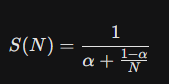

де a - частка програми, що може бути розпаралелена.

Розвязавши рівняння з експериментальним значенням 𝑆𝑒𝑥𝑝(7) = 0.1597 приходимо висновку, що розпаралелити можна близько 5% коду, що в даному випадку не має сенсу, через занадто малу вибірку даних.
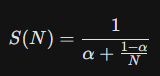
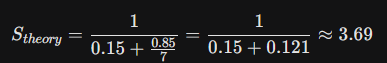
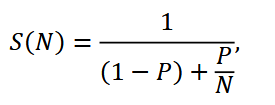

**Висновки:**

У ході виконання лабораторної роботи було досліджено принципи та механізми парного обміну в розподілених обчислювальних системах з використанням бібліотеки MPI. Було розглянуто стандартні, синхронні, буферизовані та режими готовності, виконано їх аналіз та порівняння. На основі отриманих знань побудовано шаблони програм для парного блокуючого, неблокуючого, кільцевого та спискового обміну даними. У процесі роботи було з’ясовано:

Парний обмін є базовим механізмом організації взаємодії процесів у системах з розподіленою памʼяттю. Функції MPI_Send/MPI_Recv у блокуючому режимі забезпечують коректність обміну, але можуть призводити до дедлоків за неправильного упорядкування викликів.  Неблокуючі функції MPI_Isend/MPI_Irecv підвищують потенційну продуктивність, дозволяючи перекривати обчислення і передачу даних, але вимагають додаткового контролю завершення операцій.  Режими комунікації відрізняються способом синхронізації та буферизації, що впливає на швидкодію та можливі ситуації блокування.  Реалізація парного обміну списками та кільцевого парного обміну дозволила зрозуміти особливості передавання складних структур даних між процесами. Для тестової задачі було побудовано розподілене обчислення гістограми, середнього значення та середньоквадратичного відхилення послідовності випадкових чисел, що дало змогу оцінити ефективність паралельної програми.


**Контрольні запитання**

1. Що таке атрибути повідомлення?

Атрибути повідомлення в MPI — це службова інформація, яка супроводжує власне дані і дозволяє комунікаційній системі розпізнавати та правильно доставляти повідомлення. Цю сукупність атрибутів часто називають «конвертом» повідомлення, і до неї обов'язково входять номер процесу-відправника (source rank), номер процесу-одержувача (destination rank), тег повідомлення (ідентифікатор для розрізнення повідомлень) та комунікатор (група процесів, в межах якої відбувається обмін).

2. Чи повертає функція MPI_Send код помилки, номер процесу, якому адресовано передачу?

Функція MPI_Send повертає лише код виконання операції, який зазвичай дорівнює константі MPI_SUCCESS у разі успіху або коду помилки у разі збою. Вона не повертає номер процесу, якому адресовано передачу, оскільки цей параметр (destination rank) є вхідним аргументом функції, тобто він вже відомий програмісту в момент виклику.

3. Чи відбувається повернення з функції MPI_Send, коли можна повторно використовувати параметри цієї функції або коли повідомлення залишить процес, або коли повідомлення прийнято адресатом або коли адресат ініціював прийом цього повідомлення?

Повернення з функції MPI_Send у стандартному режимі відбувається тоді, коли буфер відправлення (змінні, передані як параметри) можна безпечно використовувати повторно, тобто змінювати в ньому дані без ризику зіпсувати повідомлення, що відправляється. Це може означати, що повідомлення було скопійовано у системний буфер і функція повернулася, або ж (якщо буферизація неможлива) функція заблокувалася до моменту, поки адресат не почав прийом і дані не вийшли з процесу-відправника.

4. Чи може значення змінної count дорівнювати нулю?

Так, значення змінної count може дорівнювати нулю. Таке повідомлення називається «порожнім» і містить лише атрибути (конверт) без тіла даних; воно часто використовується для цілей синхронізації процесів, коли сам факт отримання повідомлення є сигналом, а передача даних не потрібна.

5. Чи можна як значення тега в команді посилки передати значення але міра процесу в комунікаторі?

Так, як значення тега можна використовувати число, що дорівнює номеру (рангу) процесу в комунікаторі, або будь-яке інше ціле невід'ємне число в межах, визначених реалізацією MPI. Тег — це просто ідентифікатор, і якщо логіка програми передбачає використання рангу процесу як тега для зручності, це є цілком допустимим.

6. Чи може довжина буфера одержувача бути більшою, ніж довжина прийнятого повідомлення? А меншою?

Довжина буфера одержувача може бути більшою за довжину реального повідомлення; у такому разі частина буфера просто залишиться невикористаною, і це не вважається помилкою. Однак вона не може бути меншою, оскільки спроба прийняти повідомлення, яке більше за виділений буфер, призведе до помилки переповнення (overflow error) і аварійного завершення програми або повернення коду помилки.

7. Який діапазон значень, що приймаються константами MPI_ANY_SOURCE, MPI_ANY_TAG?

Константи MPI_ANY_SOURCE та MPI_ANY_TAG зазвичай мають від'ємні значення або спеціальні значення, які знаходяться поза діапазоном допустимих рангів процесів (від 0 до N-1) та звичайних тегів. Це дозволяє функції MPI_Recv однозначно відрізняти їх від конкретних ідентифікаторів та переходити в режим прийому від будь-якого джерела або з будь-яким тегом.

8. Чи можна використовувати операції MPI_ANY_SOURCE в операції? Чому?

Операцію MPI_ANY_SOURCE (як і MPI_ANY_TAG) не можна використовувати в операціях відправлення (Send), її можна використовувати лише в операціях прийому (Recv). Це пов'язано з тим, що при відправленні повідомлення відправник повинен чітко знати, кому саме він надсилає дані, тоді як одержувач може дозволити собі чекати повідомлення від будь-кого.

9. Як визначити номер процесу-відправника, якщо під час прийому використовуються MPI_ANY_SOURCE, MPI_ANY_TAG?

Якщо при прийомі використовувалися джокери (wildcards), то реальний номер процесу-відправника та тег повідомлення можна дізнатися, перевіривши поля MPI_SOURCE та MPI_TAG у структурі status, яка передається у функцію MPI_Recv і заповнюється нею після успішного отримання повідомлення.

10. Чи означає повернення з функції MPI_Recv, що сталася помилка?

Ні, саме по собі повернення з функції MPI_Recv означає лише, що операція прийому завершилася (повідомлення отримано і записано в буфер). Щоб дізнатися, чи сталася помилка, необхідно перевірити код повернення функції: якщо він дорівнює MPI_SUCCESS, то помилки не було.

11. Чи потрібно перед викликом функції MPI_Recv звернутися до функції MPI_Get_Count?

Ні, перед викликом MPI_Recv не потрібно звертатися до MPI_Get_Count. Функція MPI_Get_Count зазвичай викликається після успішного завершення MPI_Recv (використовуючи отриманий статус), щоб дізнатися фактичний розмір отриманих даних у одиницях вказаного типу даних.

12. Чи можна використовувати функцію MPI_Recv, якщо не відомий відправник повідомлення чи тег повідомлення?

Так, функцію MPI_Recv можна використовувати навіть за відсутності інформації про відправника або тег. Для цього замість конкретного рангу відправника вказують константу MPI_ANY_SOURCE, а замість конкретного тега — MPI_ANY_TAG.

13. Як визначити довжину надісланого повідомлення?

Довжину надісланого (точніше, отриманого) повідомлення можна визначити після прийому, викликавши функцію MPI_Get_Count. Їй передається структура status (заповнена функцією MPI_Recv) та тип даних, а вона повертає кількість елементів цього типу, що містилися в повідомленні.

14. Чи завжди status.MPI_SOURCE=SOURCE, status.MPI_TAG=MPI_TAG?

Ні, не завжди. Якщо у функції MPI_Recv в аргументах SOURCE та TAG були вказані конкретні значення, то поля статусу будуть їм дорівнювати. Однак, якщо використовувалися константи MPI_ANY_SOURCE або MPI_ANY_TAG, то в status.MPI_SOURCE та status.MPI_TAG будуть записані фактичні ідентифікатори відправника та тега отриманого повідомлення, які можуть відрізнятися від "джокерів".

15. Що станеться під час виклику функції MPI_Buffer_attach, якщо недостатньо пам'яті для буфера?

Якщо системі не вдається виділити або приєднати вказаний обсяг пам'яті під час виклику MPI_Buffer_attach (хоча зазвичай пам'ять виділяє користувач і передає вказівник), функція поверне відповідний код помилки, що сигналізує про проблему з ресурсами.

16. Скільки буферів можна приєднати до процесу за один виклик MPI_Buffer_attach?

За один виклик MPI_Buffer_attach можна приєднати лише один буфер. Більше того, до одного процесу в кожен момент часу може бути приєднаний тільки один активний буфер для буферизованого обміну; якщо потрібно змінити буфер, попередній треба від'єднати.

17. У якому режимі мають бути надіслані повідомлення для використання буфера у MPI_Buffer_attach?

Для того щоб використовувався буфер, приєднаний через MPI_Buffer_attach, повідомлення повинні відправлятися у буферизованому режимі комунікації. Для цього використовуються спеціальні функції відправки, такі як MPI_Bsend.

18. Коли функція MPI_Buffer_detach може бути викликана?

Функція MPI_Buffer_detach може бути викликана тоді, коли процес завершив відправлення всіх повідомлень у буферизованому режимі і хоче повернути собі контроль над пам'яттю буфера. Якщо в буфері ще залишаються невідправлені повідомлення, функція заблокується доти, доки вони не будуть фізично передані.

19. Перерахуйте основні властивості парного обміну, які гарантує правильна реалізація MPI.

Правильна реалізація MPI гарантує надійність доставки повідомлень, збереження порядку (non-overtaking) повідомлень між тією ж парою процесів з однаковими комунікатором і тегом, а також прогрес комунікацій (операції не повинні блокуватися вічно, якщо є відповідні пари Send/Recv).

20. Чи гарантують властивості парного обміну, що програма з передачею повідомлень детермінована?

Ні, властивості парного обміну не гарантують повної детермінованості програми. Якщо використовуються операції з MPI_ANY_SOURCE, порядок обробки повідомлень залежатиме від того, яке повідомлення фізично надійде першим, що може змінюватися від запуску до запуску через затримки мережі.

21. У яких ситуаціях нестача буферного простору веде до дідлока?

Нестача буферного простору веде до дідлока (взаємного блокування), коли два процеси намагаються одночасно відправити один одному повідомлення за допомогою блокуючих операцій (MPI_Send), розмір яких перевищує доступний системний буфер. Обидві функції Send заблокуються в очікуванні Recv, але Recv не може бути викликаний, оскільки процеси застрягли на Send.

22. Сформулюйте основні правила відповідності типів даних.

Тип даних, вказаний при відправленні, повинен відповідати типу даних, вказаному при прийомі. Це означає, що сигнатури типів мають збігатися (наприклад, якщо відправляється масив цілих чисел MPI_INT, то і прийматися має масив MPI_INT). Довжина повідомлення у байтах також узгоджується, але кількість елементів може відрізнятися, якщо розмір буфера одержувача достатній.

23. Чи тягне обмін у MPI перетворення типів даних за її невідповідності?

MPI виконує перетворення представлення даних (data representation conversion), наприклад, зміну порядку байтів (little-endian vs big-endian) при передачі між різнорідними архітектурами. Проте MPI не виконує автоматичне перетворення типів даних у розумінні мов програмування (наприклад, автоматичне перетворення float у int не відбувається; типи мають відповідати).

25. Чи є MPI-програми, в яких змішані мови, які переносяться?

Так, MPI спроектований таким чином, щоб забезпечувати сумісність між різними мовами програмування (наприклад, C, C++, Fortran). Оскільки типи даних MPI стандартизовані, програми, написані різними мовами, можуть коректно обмінюватися даними, що робить змішані програми переносимими.

25. Що таке стандартний комунікаційний режим?

Стандартний комунікаційний режим — це режим відправлення (функція MPI_Send), у якому бібліотека MPI самостійно вирішує, чи використовувати буферизацію вихідного повідомлення, чи блокувати процес до початку прийому. Це компромісний режим, який не гарантує ні негайної буферизації, ні синхронності.

26. Чи буферизується вихідне повідомлення за стандартного комунікаційного режимі?

Це залежить від реалізації MPI та розміру повідомлення. Якщо повідомлення мале і є вільна системна пам'ять, MPI зазвичай буферизує його. Якщо повідомлення велике, буферизація не відбувається, і відправлення блокується. Стандарт не дає жорстких гарантій щодо буферизації у цьому режимі.

27. У разі використання функцій MPI_Send і MPI_Recv призведе до дідлоку?

Використання MPI_Send і MPI_Recv призведе до дідлоку, якщо два процеси ініціюють обмін зустрічними повідомленнями (наприклад, обидва спочатку викликають Send до іншого, а потім Recv), і при цьому системного буфера недостатньо для збереження повідомлень. У такому разі обидва Send заблокуються назавжди.

28. Перерахуйте три додаткові комунікаційні режими.

Три додаткові режими комунікації (крім стандартного) — це: 1) Буферизований режим (Buffered, MPI_Bsend), 2) Синхронний режим (Synchronous, MPI_Ssend), 3) Режим готовності (Ready, MPI_Rsend).

29. Скільки операцій прийому існує три різних режимів передачі?

Існує лише одна універсальна операція прийому — MPI_Recv (або її неблокуючий аналог MPI_Irecv). Вона здатна приймати повідомлення, надіслані в будь-якому з чотирьох режимів передачі (стандартному, буферизованому, синхронному чи по готовності).

30. Чому знадобилося введення різних комунікаційних режимів?

Різні режими були введені для того, щоб дати програмісту можливість балансувати між продуктивністю, споживанням пам'яті та потребами в синхронізації. Наприклад, стандартний режим оптимізований для загальних випадків, синхронний — для детермінованої передачі, буферизований — для уникнення блокувань ціною пам'яті, а по готовності — для максимальної швидкості за умови гарантованої синхронізації.

31. Чому посилка в стандартному режимі комунікації є локальною операцією?

Посилка в стандартному режимі є локальною операцією лише у тому випадку, якщо повідомлення успішно буферизовано системою (наприклад, воно мале). Тоді функція повертається відразу після копіювання даних у системний буфер, не чекаючи дій від одержувача.

32. Що станеться, якщо при буферизованій посилці недостатньо місця для повідомлення?

Якщо при використанні буферизованої посилки (MPI_Bsend) розмір повідомлення перевищує вільне місце у підключеному користувачем буфері (або буфер взагалі не був підключений), виклик функції завершиться помилкою.

33. У чому основна різниця між буферизованим та стандартним режимами?

Основна різниця в тому, що буферизований режим (MPI_Bsend) гарантує використання наданого користувачем буфера і завжди завершується локально (не блокує відправника), тоді як стандартний режим (MPI_Send) покладається на системні буфери і може заблокувати відправника, якщо система вирішить не буферизувати повідомлення.

34. Чи можна розглядати синхронний режим комунікацій як спосіб синхронізації процесів?

Так, синхронний режим (MPI_Ssend) можна і часто використовують як засіб синхронізації ("рандеву"), оскільки успішне завершення функції відправлення на стороні відправника гарантує, що одержувач вже дійшов до відповідної точки у коді і почав прийом повідомлення.

35. У чому основна різниця між синхронним та стандартним режимами?

Різниця полягає в умові завершення: синхронна відправка (MPI_Ssend) не завершиться, поки одержувач не почне прийом, незалежно від розміру повідомлення. Стандартна відправка (MPI_Send) може завершитися раніше, якщо повідомлення було буферизовано, навіть якщо одержувач ще не готовий.

36. У чому основна відмінність між стандартним та режимом готовності?

Режим готовності (MPI_Rsend) вимагає, щоб операція прийому (Recv) була вже ініційована на приймаючій стороні до моменту виклику Rsend, інакше результат невизначений (можлива помилка). Стандартний режим не має такої вимоги і коректно обробляє ситуацію, коли Send викликається раніше за Recv.

37. У чому різниця між блокуючим та неблокуючим обміном?

Блокуючий обмін (Send/Recv) зупиняє виконання програми до повного завершення операції (передачі даних або їх копіювання), тоді як неблокуючий обмін (Isend/Irecv) лише ініціює операцію і миттєво повертає керування програмі, дозволяючи виконувати обчислення паралельно з передачею даних.

38. Що таке приховані запити?

Приховані запити (opaque request objects) — це системні об'єкти, доступ до яких здійснюється через дескриптори типу MPI_Request. Вони зберігають інформацію про стан запущеної неблокуючої операції комунікації, але їх внутрішня структура прихована від програміста.

39. Чи вірний виклик функції MPI_IRecv(buf, 1, MPI_INT, 3, tag, comm, &status); для того, щоб прийняти одне ціле число від процесу 3?

Ні, цей виклик невірний. Останнім аргументом функції MPI_Irecv має бути вказівник на змінну типу MPI_Request (дескриптор запиту), а не на MPI_Status. Статус перевіряється пізніше, при виклику функцій MPI_Wait або MPI_Test, які використовують цей запит.

40. Визначте поняття “завершення операції посилки” для різних комунікаційних режимів.

Завершення операції посилки означає, що буфер відправлення можна безпечно перезаписувати. Для буферизованого режиму це момент копіювання в буфер; для синхронного — момент початку прийому одержувачем; для стандартного — або копіювання в системний буфер, або завершення передачі.

41. Визначте поняття “завершення операції прийому” для різних комунікаційних режимів.

Завершення операції прийому для будь-якого режиму означає, що дані повністю надійшли з мережі або буфера, записані у пам'ять одержувача і готові до використання.

42. Що таке активний та неактивний дескриптор?

Активний дескриптор (request) пов'язаний з операцією, яка була ініційована, але ще не завершена (або не пройшла процедуру очищення через Wait/Test). Неактивний дескриптор має значення MPI_REQUEST_NULL; він означає, що жодна операція з ним не пов'язана (або попередня операція вже повністю завершена і дескриптор звільнено).

43. У чому різниця використання MPI_Wait та MPI_Test?

MPI_Wait блокує виконання процесу доти, доки операція, пов'язана з дескриптором, не завершиться. MPI_Test не блокує процес: він лише перевіряє поточний стан операції, повертає логічний прапорець (завершено/не завершено) і дозволяє програмі продовжувати роботу.

44. Чи означає повернення з функції MPI_Wait, що всі процеси дійшли до бар'єра чи відправник повернувся з функції MPI_Send, чи одержувач повернувся з функції MPI_Recv, чи закінчилася асинхронно запущена операція?

Повернення з MPI_Wait означає лише те, що закінчилася конкретна асинхронна операція (Isend або Irecv), пов'язана з переданим їй запитом. Це не є глобальним бар'єром і не дає інформації про стан інших процесів, окрім тієї, що випливає з семантики завершення конкретної передачі.

45. Які властивості неблокуючого парного обміну повинні бути гарантовані правильною реалізацією MPI?

Повинна бути гарантована можливість перекриття комунікацій та обчислень (overlap), збереження порядку повідомлень (як і в блокуючому обміні) та коректне звільнення ресурсів після виклику функцій завершення (Wait/Test).

46. Закінчилася одна або всі з асинхронно запущених операцій, асоційованих із зазначеними у списку параметрів ідентифікаторами requests, якщо значення параметра flag дорівнює 1 при поверненні функції MPI_TestAll?

Якщо flag дорівнює 1 при поверненні MPI_TestAll, це означає, що закінчилися абсолютно всі операції, асоційовані з переданим масивом запитів.

47. У чому різниця використання функцій MPI_Waitany, MPI_Waitall, MPI_Waitsome?

MPI_Waitany блокує процес до завершення однієї будь-якої операції зі списку. MPI_Waitall блокує до завершення всіх операцій зі списку. MPI_Waitsome блокує до завершення хоча б однієї операції і повертає список усіх, що завершилися на даний момент.

48. У чому різниця використання функцій MPI_Waitany, MPI_Testany?

MPI_Waitany блокує виконання програми доки не завершиться хоча б одна операція. MPI_Testany не блокує виконання: вона миттєво перевіряє, чи завершилася хоча б одна операція, і якщо ні, повертає прапорець false, дозволяючи продовжити роботу.

49. Якщо кілька операцій із масиву активних запитів можуть завершитися одночасно під час виклику MPI_Waitany, який номер процесу буде обраний?

Якщо кілька операцій завершилися одночасно, MPI_Waitany поверне індекс однієї з них. Стандарт не визначає, якої саме (це залежить від реалізації), тому не можна покладатися на певний порядок вибору ("справедливість" не гарантується).

50. Що означає код MPI_ERR_Pending у статусі під час виконання функції MPI_Waitall?

Код MPI_ERR_PENDING (або аналогічний статус у масиві статусів) у контексті функцій типу Waitsome/Testsome вказує на те, що дана конкретна операція ще не завершена, в той час як функція повернула керування через завершення інших операцій або помилки в інших запитах.